In [1]:
# import libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# The following defined function shiftDetect() is able to :
# 1. Detect if mean or var shifts for continous stream data
Use Hawkins CUSUM Method described in http://rmgsc.cr.usgs.gov/outgoing/threshold_articles/Hawkins_Zamba2005b.pdf
and in Douglas C. Montgomery Statistical Quality Control 6th Edition Page 400-Page 417 Chapter Time-Weighted Control Charts
Tunable Parameters:
k : Allowance value, a threshold that signals a possible shift starts at the current position
H : If CUSUM value goes beyond this value, conclude a shift has occured and the shift starts at the last point
whose CUSUM is larger than k Allowance value
Seperate k and H values are used for mean and var shift detection

# 2. Detect concept change for attributes stream data
Function to get detect concept change for attributes data
Assign char a,b,c to uniformly distributed value seperately for all data points first
Then, group data samples into sub group first,with each group has n data points,calculate the average of each subgroup
Therefore we get a new continous data array named sample
Plot the sample and a shift can be seen obviously
To-do: Experiment using p chart, or Shewart chart or CUSUM or other methods to detect the change position
and in Douglas C. Montgomery Statistical Quality Control 6th Edition Page 400-Page 417 Chapter Time-Weighted Control Charts
Tunable Parameters:
n : subgroup sample size n 
t: The first t data points be selected as baseline
posTriple2_160,posTriple_175, posTripleDouble_175, negTriple,negWithRare,negBinary Verified

# Usage example
with open('posShiftUpVar_70.txt') as f: # Open file as f
    lines = f.read().splitlines()  # Split file line by line and put lines in to var "lines"
f.close() # Close file
try:
    data = [float(i) for i in lines] # For variable dataa stream,convert data string to float if convertable
except: 
    data = lines # Otherwise for attribute data, no convert needed     
shiftDetect(data)

In [2]:
#### Use Hawkins CUSUM Method described in http://rmgsc.cr.usgs.gov/outgoing/threshold_articles/Hawkins_Zamba2005b.pdf
#### and in Douglas C. Montgomery Statistical Quality Control 6th Edition Page 400-Page 417 Chapter Time-Weighted Control Charts
#### Tunable Parameters:
#### k : Allowance value, a threshold that signals a possible shift starts at the current position
#### H : If CUSUM value goes beyond this value, conclude a shift has occured and the shift starts at the last point
####  whose CUSUM is larger than k Allowance value
#### Seperate k and H values are used for mean and var shift detection
#### Usage example: data = np.loadtxt("posShiftUpVar_70.txt", delimiter=",") shiftDetect(data)

def CUSUMDetect(data):
    
    cusums_mean_up = []   # Ci array for mean upper shift detection
    N_mean_up = [] # N+ array for mean upper shift detection
    n_mean_up = 0 # N1 = 0
    cusum_mean_up = 0   # C1 = 0 for mean upper shift detection
    cusums_mean_lo = []   # Ci array for mean lower shift detection
    N_mean_lo = [] # N+ array for mean lower shift detection
    n_mean_lo = 0 # N1 = 0
    cusum_mean_lo = 0   # C1 = 0 for mean lower shift detection
    
    cusums_var_up = [] # Ci array for var upper shift detection
    N_var_up = [] # N+ arrary for var upper shift detection
    n_var_up = 0 # N1 = 0
    cusum_var_up = 0 # C1 = 0 for var upper shift detection
    cusums_var_lo = [] # Ci array for var lower shift detection
    N_var_lo = [] # N+ arrary for var lower shift detection
    n_var_lo = 0 # N1 = 0
    cusum_var_lo = 0 # C1 = 0 for var lower shift detection
    
    n = 50 # The first n samples form the baseline
    i = 1 # The index looping through
    mean = np.mean(data[:n]) # mean of baseline
    sd = np.std(data[:n]) # std of baseline
    k = 2 * sd  # Allowance value for mean shift detection
    H = 12 * sd # Decision interval for mean shift detection
    k_v = 1 * sd # Allowance value for var shift detection
    if mean/sd <= 2:
        H_v = 1.5 * mean/sd * sd # Decision interval for var shift detection that mean and std are close
    else:
        H_v = 5* mean/sd *sd # Decision interval for var shift detection that std is much smaller than mean
    print ("mean of 50 samples = " + str(mean))
    print ("std of 50 samples = " + str(sd))
    print ("Allowance value of mean = " + str(k))
    print ("Decision interval of mean = " + str(H))
    print ("Allowance value of variance = " + str(k_v))
    print ("Decision interval of variance = " + str(H_v))
    
    plt.plot(data)
    plt.title("All Data Points")
    plt.show()
    
    #for x in data[n+1:]: # Start building CUSUM tabular from the n+1 point
    for x in data: # Start building CUSUM tabular 
        
        ## Tabular CUSUM for mean shift detection
        # mean upper shift CUSUM tabular generation
        cusum_mean_up = max(0, x - (mean + k) + cusum_mean_up) # Ci = max(0, xi-(mean+k)+Ci-1) for mean shift detection
        
        if cusum_mean_up == 0: # if cusum value is 0 
             n_mean_up = 0    # not start recording a possible shift change, set index Number to 0
        else:
             n_mean_up = n_mean_up + 1 # else if cusum value is not 0 
        N_mean_up.append(n_mean_up) # start recording a possible shift change, increment index Number by 1
            
        cusums_mean_up.append(cusum_mean_up) # Append CUSUM
        
        # mean lower shift CUSUM tabular generation
        cusum_mean_lo = max(0, (mean - k) - x + cusum_mean_lo) # Ci = max(0, (mean-k)-xi+Ci-1) for mean shift detection
        
        if cusum_mean_lo == 0: # if cusum value is 0 
             n_mean_lo = 0     # not start recording a possible shift change, set index Number to 0
        else:
             n_mean_lo = n_mean_lo + 1 # else if cusum value is not 0 
        N_mean_lo.append(n_mean_lo)   # start recording a possible shift change, increment index Number by 1
             
        cusums_mean_lo.append(cusum_mean_lo) # Append CUSUM 
        
        ## Tabular CUSUM for var shift detection
        ## Ci  for var shift detection,Hawkins metod: yi = (xi - mean)/std, vi = (sqrt(abs(yi)) - 0.822)/0.349
        ## Si+ = max(0,vi-k+Si-1) , Si- = max(0,-k-vi+Si-1)
        
        # var upper shift CUSUM tabular generation
        y = (x - mean)/sd
        if mean/sd <= 2:
           v = ((np.sqrt(abs(y))) - 0.822) / 0.01 # v for mean and std are very close like posVarup 60 file
        else:
           v = ((np.sqrt(abs(y))) - 0.822) / 0.03  #file for std is much smaller than mean like posVarup70 file
        
        cusum_var_up = max(0, v - k_v + cusum_var_up)
        
        if cusum_var_up == 0: # if cusum value is 0 
             n_var_up = 0     # not start recording a possible shift change, set index Number to 0
        else:
             n_var_up = n_var_up + 1 # else if cusum value is not 0 
        N_var_up.append(n_var_up)   # start recording a possible shift change, increment index Number by 1
        
        cusums_var_up.append(cusum_var_up) # Append CUSUM 
        
        # var lower shift CUSUM tabular generation
        # cusum_var_lo = max(0,-v - k_v + cusum_var_up)
        cusum_var_lo = abs(-v - k_v + cusum_var_up)
        
        if cusum_var_lo == 0: # if cusum value is 0 
             n_var_lo = 0     # not start recording a possible shift change, set index Number to 0
        else:
             n_var_lo = n_var_lo + 1 # else if cusum value is not 0 
        N_var_lo.append(n_var_lo)   # start recording a possible shift change, increment index Number by 1
        
        cusums_var_lo.append(cusum_var_lo) # Append CUSUM 
        
        
        i = i + 1
        ## Decide if shift in mean or var is detected
        if cusum_mean_up > H:
           
            c_i = i - (n_mean_up - 1) # The position where change right starts
            print("Mean shifted up at position " + str(c_i))
            
            print("CUSUM = " + str(cusums_mean_up))
            plt.plot(cusums_mean_up)
            plt.title("CUSUM of MEAN UP " + str(c_i) + " observations")
            plt.show()
            return c_i
        
        if cusum_mean_lo > H:
            
            c_i = i - (n_mean_lo - 1) # The position where change right starts
            print("Mean shifted down at position " + str(c_i))
            print("CUSUM = " + str(cusums_mean_lo))
            plt.plot(cusums_mean_lo)
            plt.title("CUSUM of MEAN DOWN" + str(c_i) + " observations")
            plt.show()
            return c_i
        
        
        if cusum_var_up > H_v:
            #c_i = i + n + 1 - (n_var_up - 1) # The position where change right starts
            c_i = i  - (n_var_up - 1)
            print("Variance shifted up at position " + str(c_i))
            print("CUSUM = " + str(cusums_var_up))
            plt.plot(cusums_var_up)
            plt.title("CUSUM of VAR up" + str(c_i) + " observations")
            plt.show()
            return c_i
        
        if cusum_var_lo > H_v:
            #c_i = i + n + 1 - (n_var_lo - 1) # The position where change right starts
            c_i = i  - (n_var_lo - 1)
            print("Variance shifted down at position " + str(c_i))
            print("CUSUM = " + str(cusums_var_lo))
            plt.plot(cusums_var_lo)
            plt.title("CUSUM of VAR down" + str(c_i) + " observations")
            plt.show()
            return c_i
        
       
    print("No Change")
    
    print("CUSUM = " + str(cusums_mean_up))
    plt.plot(cusums_mean_up)
    plt.title("CUSUM of mean up")
    plt.show()
    
    print("CUSUM = " + str(cusums_mean_lo))
    plt.plot(cusums_mean_lo)
    plt.title("CUSUM of mean down")
    plt.show()
    
    print("CUSUM = " + str(cusums_var_up))
    plt.plot(cusums_var_lo)
    plt.title("CUSUM of VAR up")
    plt.show()
    
    print("CUSUM = " + str(cusums_var_lo))
    plt.plot(cusums_var_lo)
    plt.title("CUSUM of VAR down")
    plt.show()
    #plt.plot(all_cusums)
    #plt.title("CUSUM of " + str(n) + " observations")
    #plt.show()
    return -1



In [7]:
#### Function to get detect concept change for attributes data
#### Assign char a,b,c to uniformly distributed value seperately for all data points first
#### Then, group data samples into sub group first,with each group has n data points,calculate the average of each subgroup
#### Therefore we get a new continous data array named sample
#### Plot the sample and a shift can be seen obviously
#### To-do: Experiment using p chart, or Shewart chart or CUSUM or other methods to detect the change position
#### and in Douglas C. Montgomery Statistical Quality Control 6th Edition Page 400-Page 417 Chapter Time-Weighted Control Charts
#### Tunable Parameters:
#### n : subgroup sample size n 
#### t: The first t data points be selected as baseline
## posTriple2_160,posTriple_175, posTripleDouble_175, negTriple,negWithRare,negBinary Verified

def AttrToCont(lines):
    
    np.random.seed(123456789)

    data = [] # Initiate an array "data" to hold original attributes data 
    for x in lines:
        if x == 'a':    #  # Convert char a to a random number from 0 to 1 and append to data array
            #data.append(0) 
            data.append(np.random.uniform(0,1,1))
        if x == 'b':     # Convert char b to a random number from 1 to 2 and append to data array
            #data.append(1)
            data.append(np.random.uniform(1,2,1))
        if x == 'c':    # Convert char c to a random number from 2 to 3 and append to data array
            #data.append(2)
            data.append(np.random.uniform(2,3,1))
        

    n = 14 # Tunable parameter to group each n+1 data points into a new sample point
    m = len(data)/(n+1) # Number of samples converted from original data
    sample = [] # A new array to hold continous data converted from attributes data

    ## Fill in the new sample data array converted from original attributes data
    for i in range(int(m)):
        if i == 0:
            sample.append(sum(data[:n])/(n+1))   # Append the average values of each n+1 data points
        else:
            sample.append(sum(data[i*n+1:(i+1)*n])/(n+1))  # Append the average values of each n+1 data points

    print("Converted variable values are" + str(sample))
    
    return sample

In [8]:
def shewartDetect(sample):

    t = 4 # Choose the first t+1 numbers of sample points as baseline

    ## Calculate control limits using P chart method
    mean = np.average(sample[:t]) # Get the mean of baseline data
    sd = np.std(sample[:t])
    #UCL = mean + 3*np.sqrt(mean*(1-mean)/(n+1)) # Upper control limit in P chart, does not work for negtriple, tripledouble
    #LCL = mean - 3*np.sqrt(mean*(1-mean)/(n+1)) # Lower control limit in P chart,does not work for negtriple, tripledouble
    UCL = mean + 3*sd # Upper control limit in Shewart method
    LCL = mean - 3*sd # Lower control limit in Shewart method
    UWL = mean + 2*sd # Upper control limit in Shewart method
    LWL = mean - 2*sd # Lower control limit in Shewart method

    print("mean is in Shewart method:" + str(mean)) # Print the mean value of the control chart
    print("UCL is in Shewart method: " + str(UCL))  # Print the UCL value of the control chart
    print("LCL is in Shewart method: " + str(LCL))  # Print the LCL value of the control chart
    print("UWL is in Shewart method: " + str(UWL))  # Print the UCL value of the warning chart
    print("LWL is in Shewart method: " + str(LWL))  # Print the LCL value of the warning chart
    print(str(range(t+1,len(sample))))
    print(str(sample[5]))
    
    #N = [] # Array to record outside threhold points index in a trend
    n = 0 # index starts from 0 which means not a point outsidte control threshold
    m = 0 # index starts from 0 which means not a point outsidte warning threshold
    ## Detect if there is concept change occurs after the baseline sample points
    for i in range(t+1,len(sample)):
        if (sample[i] >= UCL) | (sample[i] <= LCL): # If there is a point outside threshold
            n = n + 1
            #N.append(n)
            if n == 3: # If it is the consecutive 3rd point that is outside threshold
                print("Concept change occured at position " + str((i-2)*(n+1)) + "of original attributes data")
                print("That corresponds to the "+str(i-2)+"th position on the converted data graph below")
                print("The change occur sample value is"+str(sample[i-2]))
                plt.plot(sample) # Plot the converted variable smaple data 
                plt.plot([0, len(sample)], [UCL, UCL], 'r--', color='r')  # Plot the Upper Control Limit
                plt.plot([0, len(sample)], [LCL, LCL], 'r--', color='r') # Plot the Lower Control LIMIT
                plt.text(1, UCL - 0.05, 'UCL',color='r') # Label out UCL 
                plt.text(1, LCL + 0.05, 'LCL',color='r') # Label out LCL 
                plt.plot([0, len(sample)], [UWL, UWL], 'r--', color='r')  # Plot the Upper Warning Limit
                plt.plot([0, len(sample)], [LWL, LWL], 'r--', color='r') # Plot the Lower Warning LIMIT
                plt.text(1, UWL - 0.05, 'UWL',color='r') # Label out UWL 
                plt.text(1, LWL + 0.05, 'LWL',color='r') # Label out LWL 
                plt.title("Converted Variable Plot from Original Attributes Data,Change Ocurred")
                plt.show()
                return (i - 2)*(n+1)
        elif (sample[i] >= UWL) | (sample[i] <= LWL): # If there is a point outside warning threshold:
            m = m + 1
            if m == 5: # If it is the consecutive 3rd point that is outside threshold
                print("Concept change occured at position " + str((i-4)*(n+1)) + "of original attributes data")
                print("That corresponds to the "+str(i-2)+"th position on the converted data graph below")
                print("The change occur sample value is"+str(sample[i-4]))
                plt.plot(sample) # Plot the converted variable smaple data 
                plt.plot([0, len(sample)], [UCL, UCL], 'r--', color='r')  # Plot the Upper Control Limit
                plt.plot([0, len(sample)], [LCL, LCL], 'r--', color='r') # Plot the Lower Control LIMIT
                plt.text(1, UCL - 0.05, 'UCL',color='r') # Label out UCL 
                plt.text(1, LCL + 0.05, 'LCL',color='r') # Label out LCL
                plt.plot([0, len(sample)], [UWL, UWL], 'r--', color='r')  # Plot the Upper Warning Limit
                plt.plot([0, len(sample)], [LWL, LWL], 'r--', color='r') # Plot the Lower Warning LIMIT
                plt.text(1, UWL - 0.05, 'UWL',color='r') # Label out UWL 
                plt.text(1, LWL + 0.05, 'LWL',color='r') # Label out LWL 
                plt.title("Converted Variable Plot from Original Attributes Data,Change Ocurred")
                plt.show()
                return (i - 4)*(n+1)
        else:
            n = 0
            m = 0
    
         
    
    print("No Change")
    plt.plot(sample) # Plot the converted variable smaple data 
    plt.plot([0, len(sample)], [UCL, UCL], 'r--', color='r')  # Plot the Upper Control Limit
    plt.plot([0, len(sample)], [LCL, LCL], 'r--', color='r') # Plot the Lower Control LIMIT
    plt.text(1, UCL - 0.05, 'UCL',color='r') # Label out UCL 
    plt.text(1, LCL + 0.05, 'LCL',color='r') # Label out LCL 
    plt.plot([0, len(sample)], [UWL, UWL], 'r--', color='r')  # Plot the Upper Control Limit
    plt.plot([0, len(sample)], [LWL, LWL], 'r--', color='r') # Plot the Lower Control LIMIT
    plt.text(1, UWL - 0.05, 'UWL',color='r') # Label out UCL 
    plt.text(1, LWL + 0.05, 'LWL',color='r') # Label out LCL 
    plt.title("Converted Variable Plot from Original Attributes Data")
    plt.show()

    return -1

In [26]:
## Function used to detect concept change for continous variable data stream

def shiftDetectCont(data):
    
    #shewartDetect(data)  # Use Shewart Control Chart to detect any concept change first
    
    #if (shewartDetect(data) == -1): # If no change detected by Shewart control chart
        
        #return CUSUMDetect(data)  # Then use CUSUM to detect any concept change first
    
    #else:
        
    return CUSUMDetect(data)

In [27]:
## Function used to detect concept change for continous variable data stream

def shiftDetectAtt(data):
    
    sample = AttrToCont(data) # Convert attribute data to continous variable data, and store them in sample variable
    
    return shewartDetect(sample) # Then apply continous data detection function on converted continous data
    
    #return shewartDetect(sample)

In [33]:
## Handling missing, invalid data
#import pandas as pd
#d = pd.Series([1,np.nan,'hello',None])
#print(d.dropna(axis=1,how='all'))
#d[d.notnull()]

ValueError: No axis named 1 for object type <class 'pandas.core.series.Series'>

In [23]:
## Definition of shiftDetect(data)

def shiftDetect(path):
    
    ## Provide a path, and randomly pick 10 txt files to read
    import os # import os module
    import random # import random module
    allfiles = [] # Array to hold all txt files names 
    for file in os.listdir(path): # For all the files in the current work directory
        if file.endswith(".txt"):  # If it is a txt file 
            allfiles.append(file) # Append that file name to allfiles array
    #random.shuffle(allfiles) # Randomly shuffle allfiles
    n = 13 # Tunable parameter, choose the firt n shuffled files to read
    files = allfiles[:n] # Choose the first n files
    output = [] # Output Array
    
    for i in range(0,len(files)): # Detect concept change for all the randomly selected files
        print("Reading " + files[i])
        with open(files[i]) as f: # Open file as f
            lines = f.read().splitlines()  # Split file line by line and put lines in to var "lines"
        f.close() # Close file
        output.append(files[i])
        try:
            data = [float(i) for i in lines] # For variable data stream,convert data string to float if convertable
            shiftDetectCont(data) # Apply continous detection function to see if concept changes
            output.append(shiftDetectCont(data))
        except: 
            data = lines # Otherwise for attribute data, no convert needed
            shiftDetectAtt(data) # Apply attributes detection function to see if concept changes
            output.append(shiftDetectAtt(data))
    
    print(output)

In [34]:
# randomly generate test data
### TO do: need to put those generated numbers and characters into text files with appropriate labels
import numpy as np

# sample with mean change
def sampleMean():
    have_change = np.random.choice([True, False])
    val = np.random.randint(0, 100, size=2)
    var = np.random.randint(0, 10, size=1)

    if have_change:
        position_change = np.random.randint(51, 1000)
        data1 = np.random.normal(loc=val[0], scale=var, size=position_change)
        data2 = np.random.normal(loc=val[1], scale=var, size=1000 - position_change)
        data = np.append(data1, data2)
    else:
        position_change = -1
        data = np.random.normal(loc=val[0], scale=var, size=1000)

    return data, position_change

# sample with variance change
def sampleVariance():
    have_change = np.random.choice([True, False])
    val = np.random.randint(0, 100, size=1)
    var = np.random.randint(0, 10, size=2)

    if have_change:
        position_change = np.random.randint(51, 1000)
        data1 = np.random.normal(loc=val, scale=var[0], size=position_change)
        data2 = np.random.normal(loc=val, scale=var[1], size=1000 - position_change)
        data = np.append(data1, data2)
    else:
        position_change = -1
        data = np.random.normal(loc=val, scale=var[0], size=1000)

    return data, position_change

# sample with change in probability of binary
def sampleBinary():
    have_change = np.random.choice([True, False])
    p = np.random.uniform(0, 1, size=2)
    choices = ['a', 'b']

    if have_change:
        position_change = np.random.randint(51, 1000)
        data1 = np.random.choice(choices, position_change, p=[p[0], 1 - p[0]])
        data2 = np.random.choice(choices, 1000 - position_change, p=[p[1], 1 - p[1]])
        data = np.append(data1, data2)
    else:
        position_change = -1
        data = np.random.choice(choices, 1000, p=[p[0], 1 - p[0]])

    return data, position_change


In [36]:
sampleVariance()


(array([  9.39607885,  13.48525422,   8.46638144,  13.64892466,
          4.78277046,   9.09583447,  11.4152729 ,  10.07013719,
         13.15787456,  -0.91599321,   8.16557574,   2.64145516,
          9.9655507 ,   9.90037552,  12.96808464,   4.69920495,
         10.00954032,  17.68154387,  10.0419763 ,   8.96268144,
         -0.29632064,   7.32425054,  10.77875345,  10.1008771 ,
         12.11893508,   4.1202364 ,   6.77338806,   6.19593082,
         11.30569996,   6.26514373,  15.66632525,  12.35781599,
         12.18412898,  11.36158718,  16.10376764,  14.77977199,
          3.25752251,   7.2187058 ,   5.35426931,   6.61081746,
          5.34466075,  -0.47409151,   8.97407851,   1.91652651,
         10.62322207,  -6.17086755,  10.77080086,  10.13519946,
         10.85785348,   9.7917763 ,  10.16320929,  11.5541832 ,
          9.92769849,  17.33156744,  13.71742406,  10.52345845,
         10.19088231,   9.27491875,  11.19748336,   8.9978187 ,
          9.04353719,  15.54763264,  12.

Reading negBinary.txt
Converted variable values are[array([ 1.33609049]), array([ 1.12167605]), array([ 1.23071131]), array([ 1.16218363]), array([ 0.88067961]), array([ 1.07461899]), array([ 1.10951914]), array([ 1.16689971]), array([ 1.15685959]), array([ 1.08990495]), array([ 0.98087119]), array([ 1.21766023]), array([ 1.09374622]), array([ 0.95118978]), array([ 0.80462383]), array([ 1.1366467]), array([ 1.21173939]), array([ 1.1181245]), array([ 1.00682073]), array([ 0.99303896])]
mean is in Shewart method:1.2126653702
UCL is in Shewart method: 1.45632594997
LCL is in Shewart method: 0.969004790432
UWL is in Shewart method: 1.37510575671
LWL is in Shewart method: 1.05022498369
range(5, 20)
[ 1.07461899]
No Change


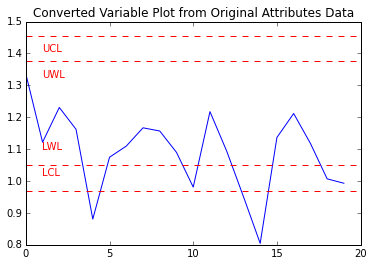

mean is in Shewart method:1.2126653702
UCL is in Shewart method: 1.45632594997
LCL is in Shewart method: 0.969004790432
UWL is in Shewart method: 1.37510575671
LWL is in Shewart method: 1.05022498369
range(5, 20)
[ 1.07461899]
No Change


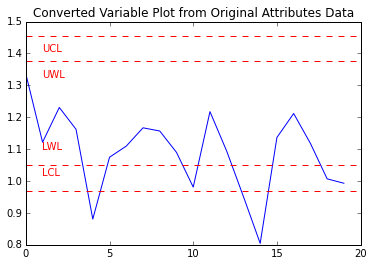

Converted variable values are[array([ 1.33609049]), array([ 1.12167605]), array([ 1.23071131]), array([ 1.16218363]), array([ 0.88067961]), array([ 1.07461899]), array([ 1.10951914]), array([ 1.16689971]), array([ 1.15685959]), array([ 1.08990495]), array([ 0.98087119]), array([ 1.21766023]), array([ 1.09374622]), array([ 0.95118978]), array([ 0.80462383]), array([ 1.1366467]), array([ 1.21173939]), array([ 1.1181245]), array([ 1.00682073]), array([ 0.99303896])]
mean is in Shewart method:1.2126653702
UCL is in Shewart method: 1.45632594997
LCL is in Shewart method: 0.969004790432
UWL is in Shewart method: 1.37510575671
LWL is in Shewart method: 1.05022498369
range(5, 20)
[ 1.07461899]
No Change


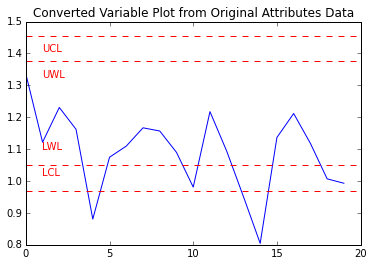

mean is in Shewart method:1.2126653702
UCL is in Shewart method: 1.45632594997
LCL is in Shewart method: 0.969004790432
UWL is in Shewart method: 1.37510575671
LWL is in Shewart method: 1.05022498369
range(5, 20)
[ 1.07461899]
No Change


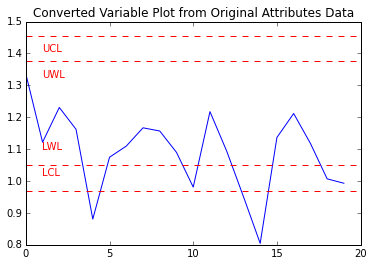

Reading negFlata.txt
mean of 50 samples = 19.9068
std of 50 samples = 1.96133443349
Allowance value of mean = 3.92266886698
Decision interval of mean = 23.5360132019
Allowance value of variance = 1.96133443349
Decision interval of variance = 99.534


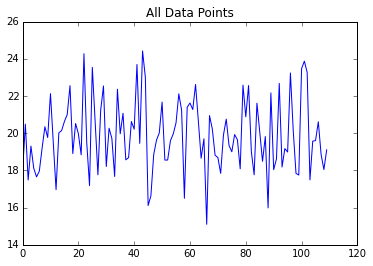

No Change
CUSUM = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.44353113301670533, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.59553113301670635, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.045531133016705638, 0, 0, 0, 0, 0, 0, 0, 0]


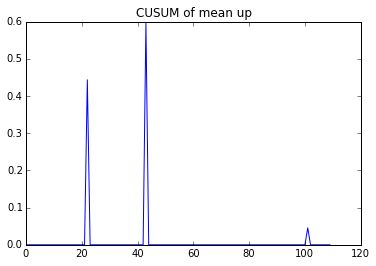

CUSUM = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.88213113301670631, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0021311330167073095, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


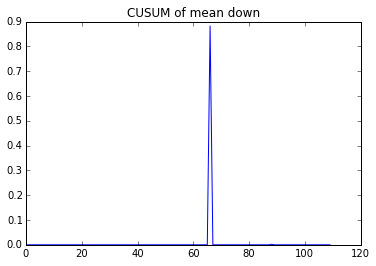

CUSUM = [4.0014349556837798, 0, 7.6634599202859235, 0, 2.4810198945435262, 8.8678061077302281, 12.733121485631784, 3.4243974650958418, 0, 0, 6.1115701900022827, 0, 11.462095484253627, 0, 0, 0, 0, 9.3787258327528509, 3.8521128845490482, 0, 0, 0, 20.372819184364573, 6.4695880982939684, 16.40439547660602, 32.410845565311831, 23.582291025697742, 29.078463274579331, 27.209575238087986, 36.471137456788391, 38.132106709955771, 23.114955986876367, 3.985465369838181, 10.197505246119929, 18.168761254439872, 0, 0, 0, 0, 0, 0, 16.970199944396327, 3.695528605909244, 24.926636399837385, 37.540917881021151, 54.557558139530983, 68.222192017465659, 63.294151310776776, 46.500328730833587, 25.075974781323584, 27.35531756134818, 25.667167709341122, 23.958538919739439, 7.8236018032982884, 0, 0, 6.0236253295826154, 4.1753355176014626, 18.7519690715622, 18.426419435377412, 20.24585728980302, 18.704710780634006, 28.548589826189247, 19.761379270772274, 17.040631916827124, 0, 22.811036846638348, 17.724820070077

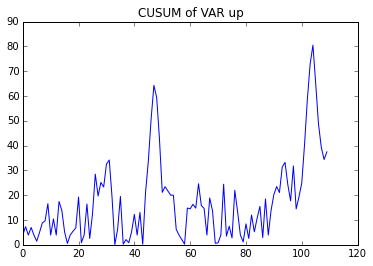

CUSUM = [3.9226688669832939, 7.3245474462760338, 3.9226688669832939, 6.9898758455186378, 3.9226688669832939, 1.4416489724397668, 4.9451372407469343, 8.8104526186484904, 9.6470000029951883, 16.57123795425505, 3.9226688669832939, 10.426777821789837, 3.9226688669832939, 17.466077095393665, 13.871076144596179, 5.1557192546240094, 0.55280116982530747, 3.9226688669832939, 5.456056965769557, 6.7700942919569371, 19.268631593291232, 0.84360609284019428, 3.9226688669832939, 16.450150317381279, 2.5469192313106728, 12.481726609622722, 28.488176698328537, 19.659622158714448, 25.155794407596037, 23.286906371104692, 32.548468589805097, 34.209437842972477, 19.192287119893074, 0.062796502854887137, 6.2748363791366373, 19.502607901911347, 0.25364462717905512, 2.1114170497227054, 0.8271508021154812, 5.2116568854354774, 12.246578027917501, 3.9226688669832939, 13.047531077413034, 0.22714026107405161, 21.003967532854091, 33.618249014037858, 50.634889272547696, 64.299523150482358, 59.371482443793482, 42.5776

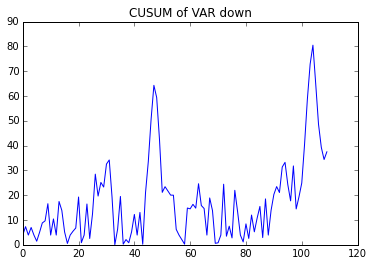

mean of 50 samples = 19.9068
std of 50 samples = 1.96133443349
Allowance value of mean = 3.92266886698
Decision interval of mean = 23.5360132019
Allowance value of variance = 1.96133443349
Decision interval of variance = 99.534


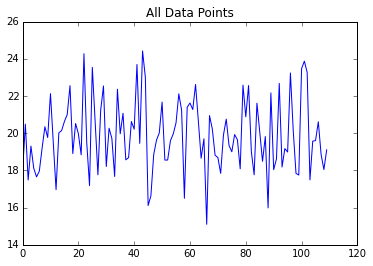

No Change
CUSUM = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.44353113301670533, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.59553113301670635, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.045531133016705638, 0, 0, 0, 0, 0, 0, 0, 0]


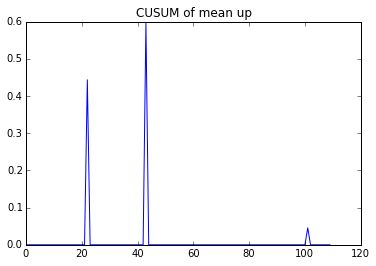

CUSUM = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.88213113301670631, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0021311330167073095, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


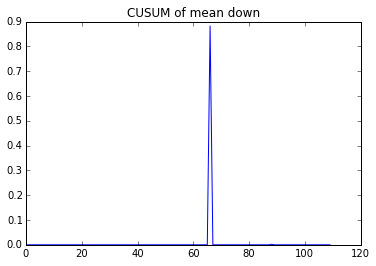

CUSUM = [4.0014349556837798, 0, 7.6634599202859235, 0, 2.4810198945435262, 8.8678061077302281, 12.733121485631784, 3.4243974650958418, 0, 0, 6.1115701900022827, 0, 11.462095484253627, 0, 0, 0, 0, 9.3787258327528509, 3.8521128845490482, 0, 0, 0, 20.372819184364573, 6.4695880982939684, 16.40439547660602, 32.410845565311831, 23.582291025697742, 29.078463274579331, 27.209575238087986, 36.471137456788391, 38.132106709955771, 23.114955986876367, 3.985465369838181, 10.197505246119929, 18.168761254439872, 0, 0, 0, 0, 0, 0, 16.970199944396327, 3.695528605909244, 24.926636399837385, 37.540917881021151, 54.557558139530983, 68.222192017465659, 63.294151310776776, 46.500328730833587, 25.075974781323584, 27.35531756134818, 25.667167709341122, 23.958538919739439, 7.8236018032982884, 0, 0, 6.0236253295826154, 4.1753355176014626, 18.7519690715622, 18.426419435377412, 20.24585728980302, 18.704710780634006, 28.548589826189247, 19.761379270772274, 17.040631916827124, 0, 22.811036846638348, 17.724820070077

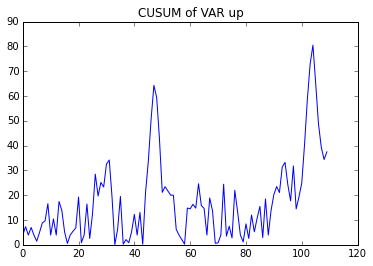

CUSUM = [3.9226688669832939, 7.3245474462760338, 3.9226688669832939, 6.9898758455186378, 3.9226688669832939, 1.4416489724397668, 4.9451372407469343, 8.8104526186484904, 9.6470000029951883, 16.57123795425505, 3.9226688669832939, 10.426777821789837, 3.9226688669832939, 17.466077095393665, 13.871076144596179, 5.1557192546240094, 0.55280116982530747, 3.9226688669832939, 5.456056965769557, 6.7700942919569371, 19.268631593291232, 0.84360609284019428, 3.9226688669832939, 16.450150317381279, 2.5469192313106728, 12.481726609622722, 28.488176698328537, 19.659622158714448, 25.155794407596037, 23.286906371104692, 32.548468589805097, 34.209437842972477, 19.192287119893074, 0.062796502854887137, 6.2748363791366373, 19.502607901911347, 0.25364462717905512, 2.1114170497227054, 0.8271508021154812, 5.2116568854354774, 12.246578027917501, 3.9226688669832939, 13.047531077413034, 0.22714026107405161, 21.003967532854091, 33.618249014037858, 50.634889272547696, 64.299523150482358, 59.371482443793482, 42.5776

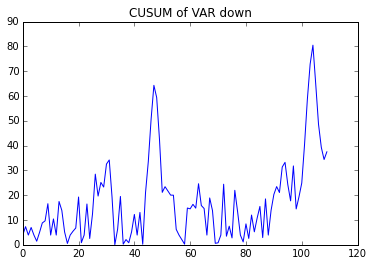

Reading negFlatb.txt
mean of 50 samples = 19.9068
std of 50 samples = 1.96133443349
Allowance value of mean = 3.92266886698
Decision interval of mean = 23.5360132019
Allowance value of variance = 1.96133443349
Decision interval of variance = 99.534


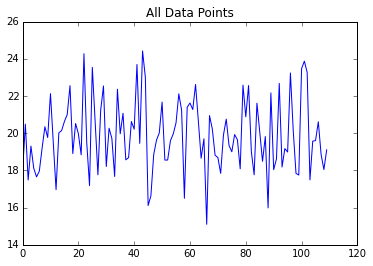

No Change
CUSUM = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.44353113301670533, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.59553113301670635, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.045531133016705638, 0, 0, 0, 0, 0, 0, 0, 0]


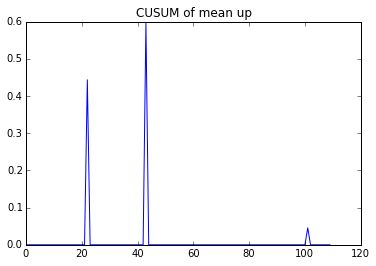

CUSUM = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.88213113301670631, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0021311330167073095, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


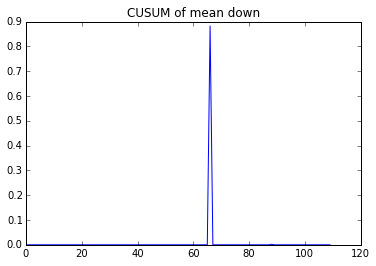

CUSUM = [4.0014349556837798, 0, 7.6634599202859235, 0, 2.4810198945435262, 8.8678061077302281, 12.733121485631784, 3.4243974650958418, 0, 0, 6.1115701900022827, 0, 11.462095484253627, 0, 0, 0, 0, 9.3787258327528509, 3.8521128845490482, 0, 0, 0, 20.372819184364573, 6.4695880982939684, 16.40439547660602, 32.410845565311831, 23.582291025697742, 29.078463274579331, 27.209575238087986, 36.471137456788391, 38.132106709955771, 23.114955986876367, 3.985465369838181, 10.197505246119929, 18.168761254439872, 0, 0, 0, 0, 0, 0, 16.970199944396327, 3.695528605909244, 24.926636399837385, 37.540917881021151, 54.557558139530983, 68.222192017465659, 63.294151310776776, 46.500328730833587, 25.075974781323584, 27.35531756134818, 25.667167709341122, 23.958538919739439, 7.8236018032982884, 0, 0, 6.0236253295826154, 4.1753355176014626, 18.7519690715622, 18.426419435377412, 20.24585728980302, 18.704710780634006, 28.548589826189247, 19.761379270772274, 17.040631916827124, 0, 22.811036846638348, 17.724820070077

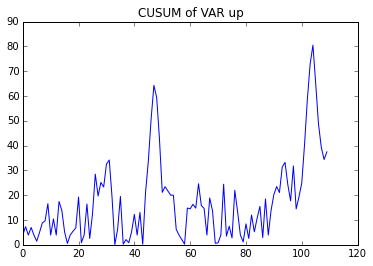

CUSUM = [3.9226688669832939, 7.3245474462760338, 3.9226688669832939, 6.9898758455186378, 3.9226688669832939, 1.4416489724397668, 4.9451372407469343, 8.8104526186484904, 9.6470000029951883, 16.57123795425505, 3.9226688669832939, 10.426777821789837, 3.9226688669832939, 17.466077095393665, 13.871076144596179, 5.1557192546240094, 0.55280116982530747, 3.9226688669832939, 5.456056965769557, 6.7700942919569371, 19.268631593291232, 0.84360609284019428, 3.9226688669832939, 16.450150317381279, 2.5469192313106728, 12.481726609622722, 28.488176698328537, 19.659622158714448, 25.155794407596037, 23.286906371104692, 32.548468589805097, 34.209437842972477, 19.192287119893074, 0.062796502854887137, 6.2748363791366373, 19.502607901911347, 0.25364462717905512, 2.1114170497227054, 0.8271508021154812, 5.2116568854354774, 12.246578027917501, 3.9226688669832939, 13.047531077413034, 0.22714026107405161, 21.003967532854091, 33.618249014037858, 50.634889272547696, 64.299523150482358, 59.371482443793482, 42.5776

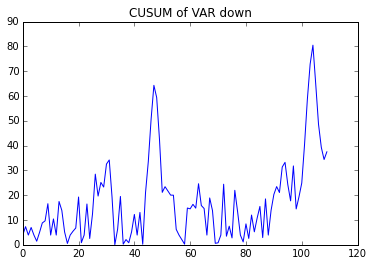

mean of 50 samples = 19.9068
std of 50 samples = 1.96133443349
Allowance value of mean = 3.92266886698
Decision interval of mean = 23.5360132019
Allowance value of variance = 1.96133443349
Decision interval of variance = 99.534


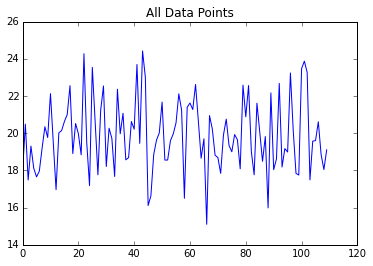

No Change
CUSUM = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.44353113301670533, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.59553113301670635, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.045531133016705638, 0, 0, 0, 0, 0, 0, 0, 0]


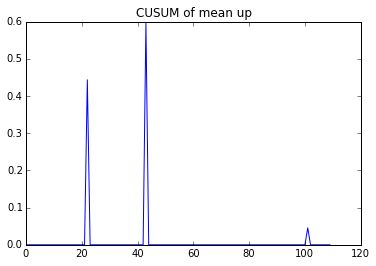

CUSUM = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.88213113301670631, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0021311330167073095, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


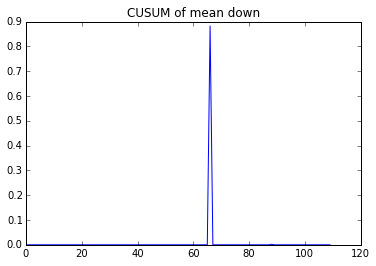

CUSUM = [4.0014349556837798, 0, 7.6634599202859235, 0, 2.4810198945435262, 8.8678061077302281, 12.733121485631784, 3.4243974650958418, 0, 0, 6.1115701900022827, 0, 11.462095484253627, 0, 0, 0, 0, 9.3787258327528509, 3.8521128845490482, 0, 0, 0, 20.372819184364573, 6.4695880982939684, 16.40439547660602, 32.410845565311831, 23.582291025697742, 29.078463274579331, 27.209575238087986, 36.471137456788391, 38.132106709955771, 23.114955986876367, 3.985465369838181, 10.197505246119929, 18.168761254439872, 0, 0, 0, 0, 0, 0, 16.970199944396327, 3.695528605909244, 24.926636399837385, 37.540917881021151, 54.557558139530983, 68.222192017465659, 63.294151310776776, 46.500328730833587, 25.075974781323584, 27.35531756134818, 25.667167709341122, 23.958538919739439, 7.8236018032982884, 0, 0, 6.0236253295826154, 4.1753355176014626, 18.7519690715622, 18.426419435377412, 20.24585728980302, 18.704710780634006, 28.548589826189247, 19.761379270772274, 17.040631916827124, 0, 22.811036846638348, 17.724820070077

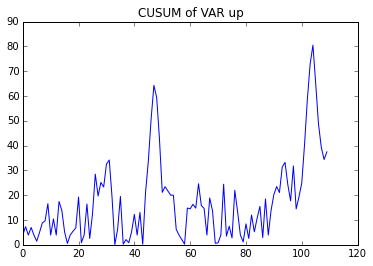

CUSUM = [3.9226688669832939, 7.3245474462760338, 3.9226688669832939, 6.9898758455186378, 3.9226688669832939, 1.4416489724397668, 4.9451372407469343, 8.8104526186484904, 9.6470000029951883, 16.57123795425505, 3.9226688669832939, 10.426777821789837, 3.9226688669832939, 17.466077095393665, 13.871076144596179, 5.1557192546240094, 0.55280116982530747, 3.9226688669832939, 5.456056965769557, 6.7700942919569371, 19.268631593291232, 0.84360609284019428, 3.9226688669832939, 16.450150317381279, 2.5469192313106728, 12.481726609622722, 28.488176698328537, 19.659622158714448, 25.155794407596037, 23.286906371104692, 32.548468589805097, 34.209437842972477, 19.192287119893074, 0.062796502854887137, 6.2748363791366373, 19.502607901911347, 0.25364462717905512, 2.1114170497227054, 0.8271508021154812, 5.2116568854354774, 12.246578027917501, 3.9226688669832939, 13.047531077413034, 0.22714026107405161, 21.003967532854091, 33.618249014037858, 50.634889272547696, 64.299523150482358, 59.371482443793482, 42.5776

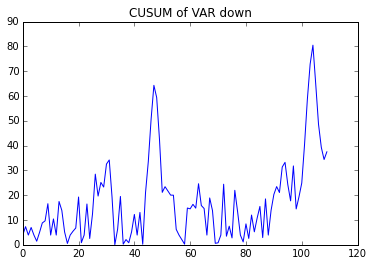

Reading negTriple.txt
Converted variable values are[array([ 1.60275716]), array([ 1.78834272]), array([ 1.89737797]), array([ 1.69551696]), array([ 1.54734628]), array([ 1.94128565]), array([ 1.77618581]), array([ 1.90023305]), array([ 1.89019293]), array([ 1.75657161]), array([ 1.51420452]), array([ 1.4843269]), array([ 1.76041289]), array([ 1.88452312]), array([ 1.6712905]), array([ 1.40331336]), array([ 1.61173939]), array([ 1.85145783]), array([ 1.94015406]), array([ 1.52637229]), array([ 1.91041731]), array([ 1.78202853]), array([ 1.7792361])]
mean is in Shewart method:1.74599870353
UCL is in Shewart method: 2.07386193902
LCL is in Shewart method: 1.41813546805
UWL is in Shewart method: 1.96457419386
LWL is in Shewart method: 1.52742321321
range(5, 23)
[ 1.94128565]
No Change


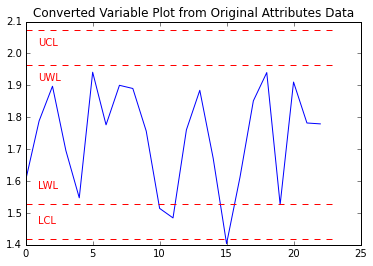

mean is in Shewart method:1.74599870353
UCL is in Shewart method: 2.07386193902
LCL is in Shewart method: 1.41813546805
UWL is in Shewart method: 1.96457419386
LWL is in Shewart method: 1.52742321321
range(5, 23)
[ 1.94128565]
No Change


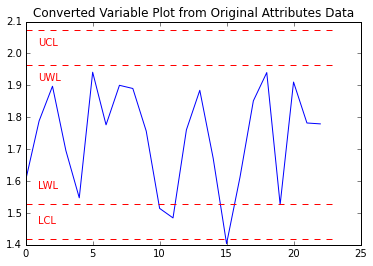

Converted variable values are[array([ 1.60275716]), array([ 1.78834272]), array([ 1.89737797]), array([ 1.69551696]), array([ 1.54734628]), array([ 1.94128565]), array([ 1.77618581]), array([ 1.90023305]), array([ 1.89019293]), array([ 1.75657161]), array([ 1.51420452]), array([ 1.4843269]), array([ 1.76041289]), array([ 1.88452312]), array([ 1.6712905]), array([ 1.40331336]), array([ 1.61173939]), array([ 1.85145783]), array([ 1.94015406]), array([ 1.52637229]), array([ 1.91041731]), array([ 1.78202853]), array([ 1.7792361])]
mean is in Shewart method:1.74599870353
UCL is in Shewart method: 2.07386193902
LCL is in Shewart method: 1.41813546805
UWL is in Shewart method: 1.96457419386
LWL is in Shewart method: 1.52742321321
range(5, 23)
[ 1.94128565]
No Change


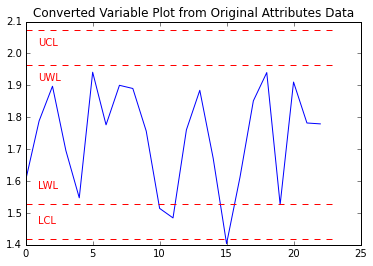

mean is in Shewart method:1.74599870353
UCL is in Shewart method: 2.07386193902
LCL is in Shewart method: 1.41813546805
UWL is in Shewart method: 1.96457419386
LWL is in Shewart method: 1.52742321321
range(5, 23)
[ 1.94128565]
No Change


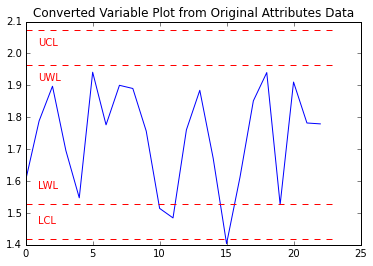

Reading negWithRare.txt
Converted variable values are[array([ 1.06942383]), array([ 0.72167605]), array([ 0.89737797]), array([ 0.76218363]), array([ 0.68067961]), array([ 0.54128565]), array([ 0.77618581]), array([ 0.83356638]), array([ 0.62352626]), array([ 0.82323828]), array([ 0.71420452]), array([ 1.15099356]), array([ 0.82707956]), array([ 0.75118978]), array([ 0.60462383]), array([ 0.9366467]), array([ 0.87840606]), array([ 0.65145783]), array([ 0.74015406]), array([ 0.72637229]), array([ 0.71041731]), array([ 0.98202853]), array([ 0.7792361]), array([ 0.66864395]), array([ 0.96361024]), array([ 0.70643201]), array([ 0.73424477]), array([ 0.72453477]), array([ 0.97051156]), array([ 0.75503819]), array([ 0.67534252]), array([ 0.76086086]), array([ 0.7386164])]
mean is in Shewart method:0.862665370199
UCL is in Shewart method: 1.27051256364
LCL is in Shewart method: 0.454818176755
UWL is in Shewart method: 1.13456349916
LWL is in Shewart method: 0.590767241236
range(5, 33)
[ 0.541

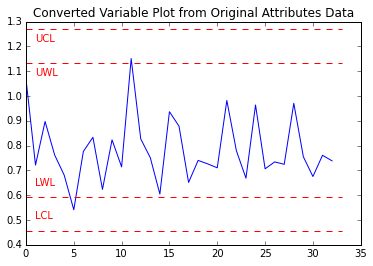

mean is in Shewart method:0.862665370199
UCL is in Shewart method: 1.27051256364
LCL is in Shewart method: 0.454818176755
UWL is in Shewart method: 1.13456349916
LWL is in Shewart method: 0.590767241236
range(5, 33)
[ 0.54128565]
No Change


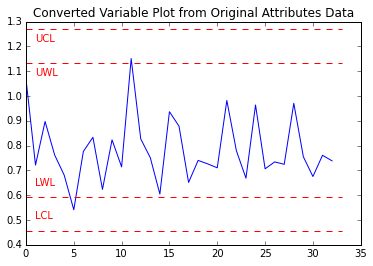

Converted variable values are[array([ 1.06942383]), array([ 0.72167605]), array([ 0.89737797]), array([ 0.76218363]), array([ 0.68067961]), array([ 0.54128565]), array([ 0.77618581]), array([ 0.83356638]), array([ 0.62352626]), array([ 0.82323828]), array([ 0.71420452]), array([ 1.15099356]), array([ 0.82707956]), array([ 0.75118978]), array([ 0.60462383]), array([ 0.9366467]), array([ 0.87840606]), array([ 0.65145783]), array([ 0.74015406]), array([ 0.72637229]), array([ 0.71041731]), array([ 0.98202853]), array([ 0.7792361]), array([ 0.66864395]), array([ 0.96361024]), array([ 0.70643201]), array([ 0.73424477]), array([ 0.72453477]), array([ 0.97051156]), array([ 0.75503819]), array([ 0.67534252]), array([ 0.76086086]), array([ 0.7386164])]
mean is in Shewart method:0.862665370199
UCL is in Shewart method: 1.27051256364
LCL is in Shewart method: 0.454818176755
UWL is in Shewart method: 1.13456349916
LWL is in Shewart method: 0.590767241236
range(5, 33)
[ 0.54128565]
No Change


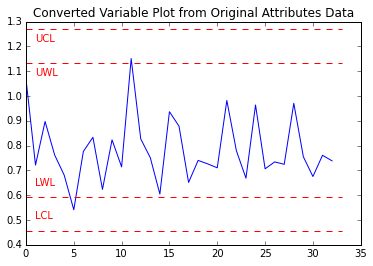

mean is in Shewart method:0.862665370199
UCL is in Shewart method: 1.27051256364
LCL is in Shewart method: 0.454818176755
UWL is in Shewart method: 1.13456349916
LWL is in Shewart method: 0.590767241236
range(5, 33)
[ 0.54128565]
No Change


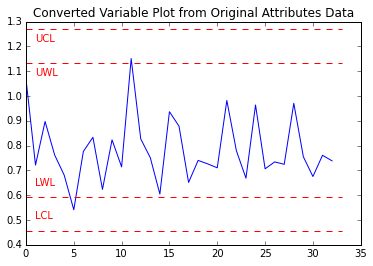

Reading posBinary_150.txt
Converted variable values are[array([ 1.13609049]), array([ 0.78834272]), array([ 1.03071131]), array([ 1.09551696]), array([ 0.94734628]), array([ 1.00795232]), array([ 0.70951914]), array([ 1.16689971]), array([ 1.15685959]), array([ 0.88990495]), array([ 0.91420452]), array([ 0.75099356]), array([ 0.49374622]), array([ 0.81785645]), array([ 0.60462383]), array([ 0.5366467]), array([ 0.67840606]), array([ 0.65145783]), array([ 0.6734874]), array([ 0.39303896]), array([ 0.77708397])]
mean is in Shewart method:1.0126653702
UCL is in Shewart method: 1.4172330692
LCL is in Shewart method: 0.608097671199
UWL is in Shewart method: 1.28237716953
LWL is in Shewart method: 0.742953570866
range(5, 21)
[ 1.00795232]
Concept change occured at position 68of original attributes data
That corresponds to the 17th position on the converted data graph below
The change occur sample value is[ 0.65145783]


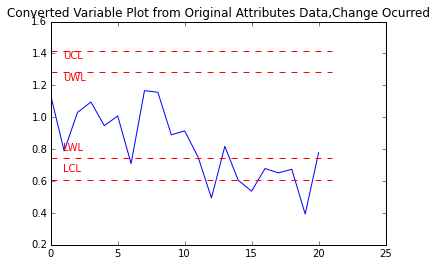

mean is in Shewart method:1.0126653702
UCL is in Shewart method: 1.4172330692
LCL is in Shewart method: 0.608097671199
UWL is in Shewart method: 1.28237716953
LWL is in Shewart method: 0.742953570866
range(5, 21)
[ 1.00795232]
Concept change occured at position 68of original attributes data
That corresponds to the 17th position on the converted data graph below
The change occur sample value is[ 0.65145783]


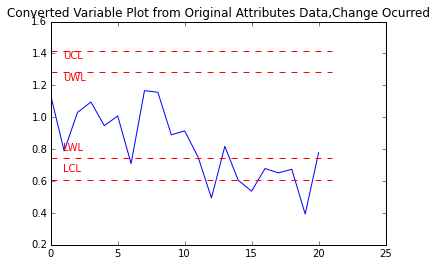

Converted variable values are[array([ 1.13609049]), array([ 0.78834272]), array([ 1.03071131]), array([ 1.09551696]), array([ 0.94734628]), array([ 1.00795232]), array([ 0.70951914]), array([ 1.16689971]), array([ 1.15685959]), array([ 0.88990495]), array([ 0.91420452]), array([ 0.75099356]), array([ 0.49374622]), array([ 0.81785645]), array([ 0.60462383]), array([ 0.5366467]), array([ 0.67840606]), array([ 0.65145783]), array([ 0.6734874]), array([ 0.39303896]), array([ 0.77708397])]
mean is in Shewart method:1.0126653702
UCL is in Shewart method: 1.4172330692
LCL is in Shewart method: 0.608097671199
UWL is in Shewart method: 1.28237716953
LWL is in Shewart method: 0.742953570866
range(5, 21)
[ 1.00795232]
Concept change occured at position 68of original attributes data
That corresponds to the 17th position on the converted data graph below
The change occur sample value is[ 0.65145783]


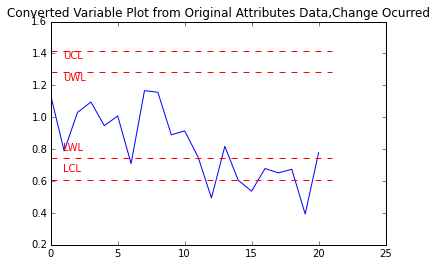

mean is in Shewart method:1.0126653702
UCL is in Shewart method: 1.4172330692
LCL is in Shewart method: 0.608097671199
UWL is in Shewart method: 1.28237716953
LWL is in Shewart method: 0.742953570866
range(5, 21)
[ 1.00795232]
Concept change occured at position 68of original attributes data
That corresponds to the 17th position on the converted data graph below
The change occur sample value is[ 0.65145783]


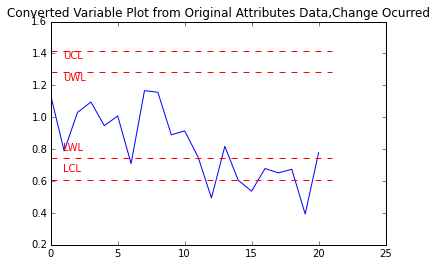

Reading posShiftDownMean_90.txt
mean of 50 samples = 79.06282
std of 50 samples = 6.85063004019
Allowance value of mean = 13.7012600804
Decision interval of mean = 82.2075604823
Allowance value of variance = 6.85063004019
Decision interval of variance = 395.3141


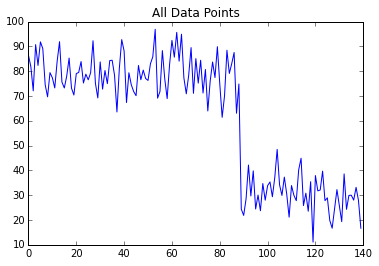

Mean shifted down at position 91
CUSUM = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.7965599196132302, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.398559919613227, 0, 0, 0, 0, 0, 3.9635599196132247, 0, 0, 0, 0, 0, 2.3245599196132289, 0, 40.995559919613228, 84.502119839226452]


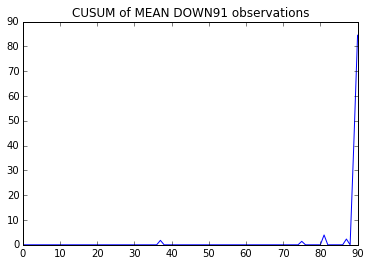

mean of 50 samples = 79.06282
std of 50 samples = 6.85063004019
Allowance value of mean = 13.7012600804
Decision interval of mean = 82.2075604823
Allowance value of variance = 6.85063004019
Decision interval of variance = 395.3141


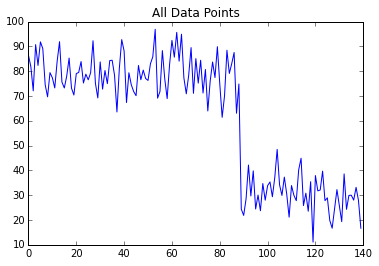

Mean shifted down at position 91
CUSUM = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.7965599196132302, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.398559919613227, 0, 0, 0, 0, 0, 3.9635599196132247, 0, 0, 0, 0, 0, 2.3245599196132289, 0, 40.995559919613228, 84.502119839226452]


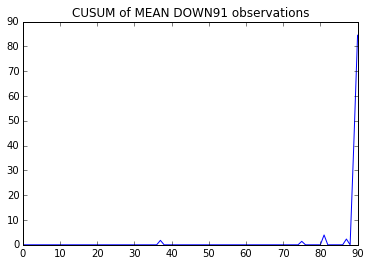

Reading posShiftUpMean_70.txt
mean of 50 samples = 60.23598
std of 50 samples = 5.79697087621
Allowance value of mean = 11.5939417524
Decision interval of mean = 69.5636505145
Allowance value of variance = 5.79697087621
Decision interval of variance = 301.1799


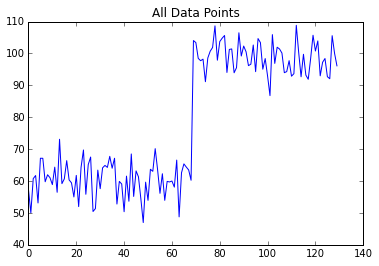

Mean shifted up at position 71
CUSUM = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.2690782475846589, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 32.233078247584658, 63.816156495169309, 90.452234742753959]


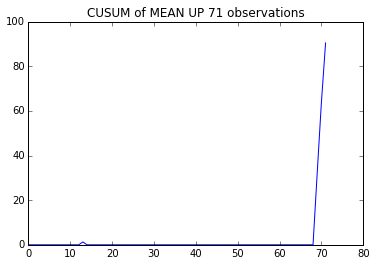

mean of 50 samples = 60.23598
std of 50 samples = 5.79697087621
Allowance value of mean = 11.5939417524
Decision interval of mean = 69.5636505145
Allowance value of variance = 5.79697087621
Decision interval of variance = 301.1799


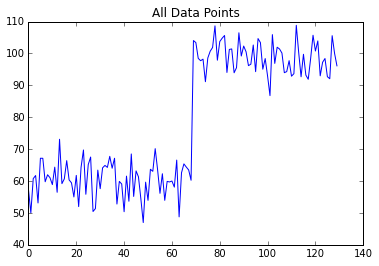

Mean shifted up at position 71
CUSUM = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.2690782475846589, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 32.233078247584658, 63.816156495169309, 90.452234742753959]


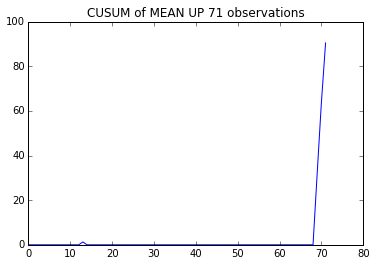

Reading posShiftUpVar_60.txt
mean of 50 samples = 50.62006
std of 50 samples = 31.376901665
Allowance value of mean = 62.75380333
Decision interval of mean = 376.52281998
Allowance value of variance = 31.376901665
Decision interval of variance = 75.93009


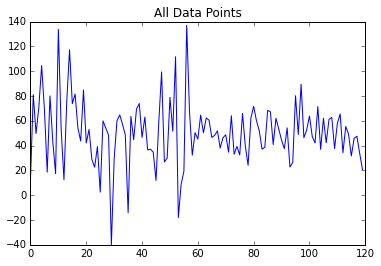

Variance shifted up at position 54
CUSUM = [0, 0, 0, 0, 17.550809187713483, 0, 0, 0, 0, 0, 49.205578222937078, 0, 0, 0, 32.180523703415069, 4.4526296025586518, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10.306016352645678, 0, 0, 0, 56.276631352657176, 24.608792381459452, 0, 0, 0, 0, 30.07843570811368, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11.121277991288125, 0, 0, 0, 0, 25.889630141449629, 60.241750529797841, 62.319943076463858, 48.409690566085985, 100.80854799341837]


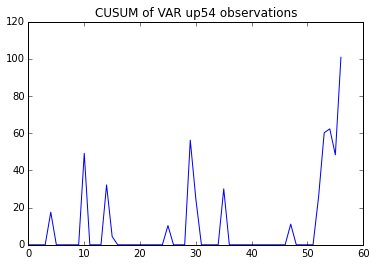

mean of 50 samples = 50.62006
std of 50 samples = 31.376901665
Allowance value of mean = 62.75380333
Decision interval of mean = 376.52281998
Allowance value of variance = 31.376901665
Decision interval of variance = 75.93009


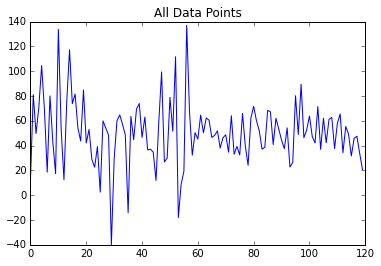

Variance shifted up at position 54
CUSUM = [0, 0, 0, 0, 17.550809187713483, 0, 0, 0, 0, 0, 49.205578222937078, 0, 0, 0, 32.180523703415069, 4.4526296025586518, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10.306016352645678, 0, 0, 0, 56.276631352657176, 24.608792381459452, 0, 0, 0, 0, 30.07843570811368, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11.121277991288125, 0, 0, 0, 0, 25.889630141449629, 60.241750529797841, 62.319943076463858, 48.409690566085985, 100.80854799341837]


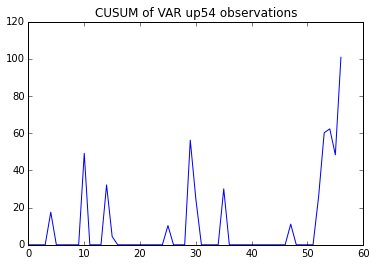

Reading posShiftUpVar_70.txt
mean of 50 samples = 51.76658
std of 50 samples = 8.73915753168
Allowance value of mean = 17.4783150634
Decision interval of mean = 104.86989038
Allowance value of variance = 8.73915753168
Decision interval of variance = 258.8329


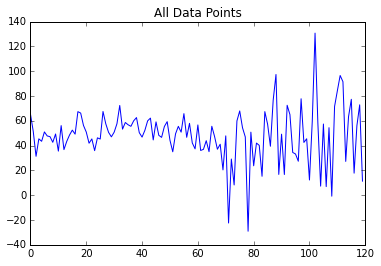

Variance shifted up at position 69
CUSUM = [5.4549543954453164, 0, 14.782360766753115, 6.9642804893311325, 3.2858190090899209, 0, 0, 0, 0, 0, 9.2539223194664544, 0, 7.53378583309145, 4.0408416668201124, 0, 0, 0, 8.418340454987316, 15.146793103375609, 2.9201742067432814, 0, 0, 0, 8.7185938893284245, 0, 0, 8.6048497321276756, 0, 0, 0, 0, 0, 15.039930087253484, 0, 0, 0, 0, 0, 0.9636226263460248, 0, 0, 0, 0, 0.21066595625647366, 0, 0, 0, 0, 0, 0, 0, 10.012235209500027, 0, 0, 0, 6.0633774391890416, 0, 0, 0, 6.645564174995771, 0, 8.5282901045742037, 15.727459016991807, 11.11310219931007, 20.987387101647666, 6.8818472451547947, 0, 7.0978377793148848, 7.7572204627384682, 34.764645559843359, 20.937668397333152, 81.929836717732115, 99.390744393549426, 137.62734676133778, 133.62380917692019, 142.85369337261312, 125.06459170430887, 113.65392075561608, 178.88057631414807, 153.58358868639419, 177.16907752751086, 176.20323690794845, 178.45714072606177, 210.45312578944703, 218.89999140736248, 209.0272

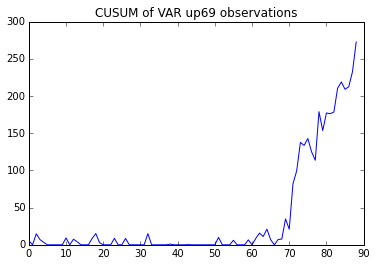

mean of 50 samples = 51.76658
std of 50 samples = 8.73915753168
Allowance value of mean = 17.4783150634
Decision interval of mean = 104.86989038
Allowance value of variance = 8.73915753168
Decision interval of variance = 258.8329


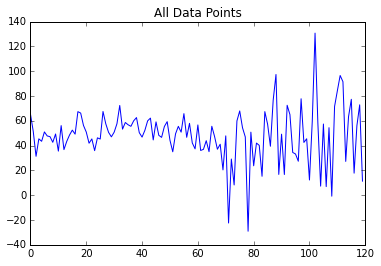

Variance shifted up at position 69
CUSUM = [5.4549543954453164, 0, 14.782360766753115, 6.9642804893311325, 3.2858190090899209, 0, 0, 0, 0, 0, 9.2539223194664544, 0, 7.53378583309145, 4.0408416668201124, 0, 0, 0, 8.418340454987316, 15.146793103375609, 2.9201742067432814, 0, 0, 0, 8.7185938893284245, 0, 0, 8.6048497321276756, 0, 0, 0, 0, 0, 15.039930087253484, 0, 0, 0, 0, 0, 0.9636226263460248, 0, 0, 0, 0, 0.21066595625647366, 0, 0, 0, 0, 0, 0, 0, 10.012235209500027, 0, 0, 0, 6.0633774391890416, 0, 0, 0, 6.645564174995771, 0, 8.5282901045742037, 15.727459016991807, 11.11310219931007, 20.987387101647666, 6.8818472451547947, 0, 7.0978377793148848, 7.7572204627384682, 34.764645559843359, 20.937668397333152, 81.929836717732115, 99.390744393549426, 137.62734676133778, 133.62380917692019, 142.85369337261312, 125.06459170430887, 113.65392075561608, 178.88057631414807, 153.58358868639419, 177.16907752751086, 176.20323690794845, 178.45714072606177, 210.45312578944703, 218.89999140736248, 209.0272

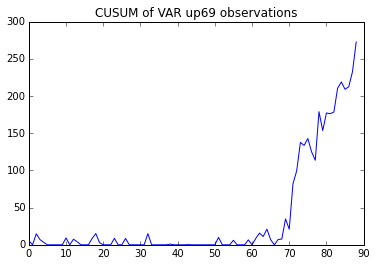

Reading posTriple2_160.txt
Converted variable values are[array([ 1.26942383]), array([ 1.52167605]), array([ 1.49737797]), array([ 1.56218363]), array([ 1.14734628]), array([ 1.60795232]), array([ 1.57618581]), array([ 1.43356638]), array([ 1.49019293]), array([ 1.42323828]), array([ 1.64753786]), array([ 1.41766023]), array([ 1.16041289]), array([ 0.81785645]), array([ 1.20462383]), array([ 0.9366467]), array([ 0.94507273]), array([ 1.05145783]), array([ 0.94015406]), array([ 0.92637229]), array([ 1.04375064])]
mean is in Shewart method:1.4626653702
UCL is in Shewart method: 1.8044988922
LCL is in Shewart method: 1.1208318482
UWL is in Shewart method: 1.69055438486
LWL is in Shewart method: 1.23477635553
range(5, 21)
[ 1.60795232]
Concept change occured at position 56of original attributes data
That corresponds to the 14th position on the converted data graph below
The change occur sample value is[ 1.20462383]


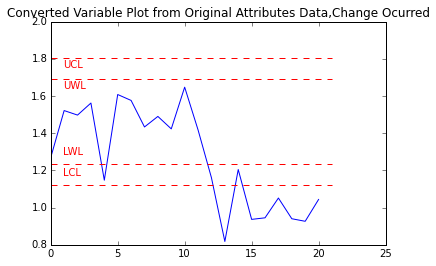

mean is in Shewart method:1.4626653702
UCL is in Shewart method: 1.8044988922
LCL is in Shewart method: 1.1208318482
UWL is in Shewart method: 1.69055438486
LWL is in Shewart method: 1.23477635553
range(5, 21)
[ 1.60795232]
Concept change occured at position 56of original attributes data
That corresponds to the 14th position on the converted data graph below
The change occur sample value is[ 1.20462383]


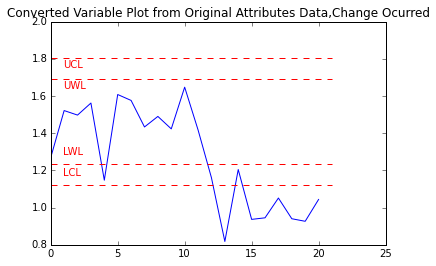

Converted variable values are[array([ 1.26942383]), array([ 1.52167605]), array([ 1.49737797]), array([ 1.56218363]), array([ 1.14734628]), array([ 1.60795232]), array([ 1.57618581]), array([ 1.43356638]), array([ 1.49019293]), array([ 1.42323828]), array([ 1.64753786]), array([ 1.41766023]), array([ 1.16041289]), array([ 0.81785645]), array([ 1.20462383]), array([ 0.9366467]), array([ 0.94507273]), array([ 1.05145783]), array([ 0.94015406]), array([ 0.92637229]), array([ 1.04375064])]
mean is in Shewart method:1.4626653702
UCL is in Shewart method: 1.8044988922
LCL is in Shewart method: 1.1208318482
UWL is in Shewart method: 1.69055438486
LWL is in Shewart method: 1.23477635553
range(5, 21)
[ 1.60795232]
Concept change occured at position 56of original attributes data
That corresponds to the 14th position on the converted data graph below
The change occur sample value is[ 1.20462383]


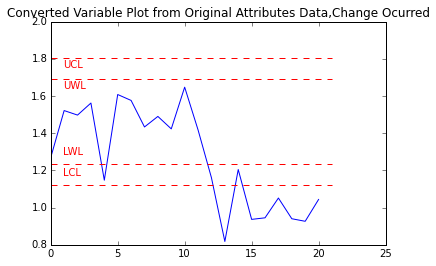

mean is in Shewart method:1.4626653702
UCL is in Shewart method: 1.8044988922
LCL is in Shewart method: 1.1208318482
UWL is in Shewart method: 1.69055438486
LWL is in Shewart method: 1.23477635553
range(5, 21)
[ 1.60795232]
Concept change occured at position 56of original attributes data
That corresponds to the 14th position on the converted data graph below
The change occur sample value is[ 1.20462383]


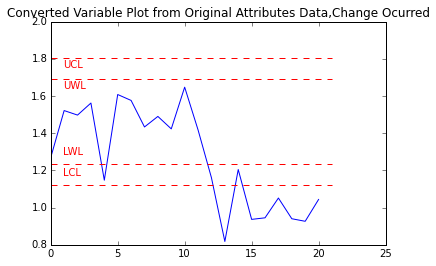

Reading posTripleDouble_175.txt
Converted variable values are[array([ 1.66942383]), array([ 1.45500939]), array([ 1.43071131]), array([ 1.36218363]), array([ 1.14734628]), array([ 1.20795232]), array([ 1.37618581]), array([ 1.23356638]), array([ 1.22352626]), array([ 1.28990495]), array([ 1.18087119]), array([ 1.35099356]), array([ 0.82707956]), array([ 0.75118978]), array([ 0.73795716]), array([ 0.7366467]), array([ 0.54507273]), array([ 0.65145783]), array([ 0.6734874]), array([ 0.79303896]), array([ 0.64375064]), array([ 0.8486952]), array([ 0.7792361])]
mean is in Shewart method:1.47933203687
UCL is in Shewart method: 1.82405215787
LCL is in Shewart method: 1.13461191586
UWL is in Shewart method: 1.70914545087
LWL is in Shewart method: 1.24951862286
range(5, 23)
[ 1.20795232]
Concept change occured at position 48of original attributes data
That corresponds to the 12th position on the converted data graph below
The change occur sample value is[ 0.82707956]


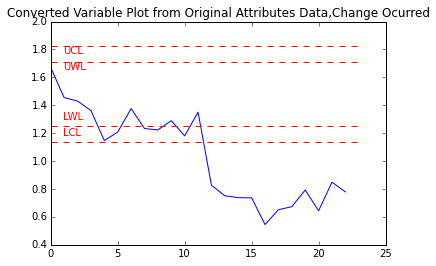

mean is in Shewart method:1.47933203687
UCL is in Shewart method: 1.82405215787
LCL is in Shewart method: 1.13461191586
UWL is in Shewart method: 1.70914545087
LWL is in Shewart method: 1.24951862286
range(5, 23)
[ 1.20795232]
Concept change occured at position 48of original attributes data
That corresponds to the 12th position on the converted data graph below
The change occur sample value is[ 0.82707956]


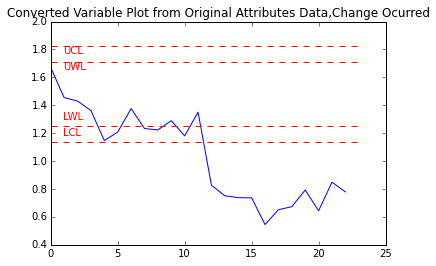

Converted variable values are[array([ 1.66942383]), array([ 1.45500939]), array([ 1.43071131]), array([ 1.36218363]), array([ 1.14734628]), array([ 1.20795232]), array([ 1.37618581]), array([ 1.23356638]), array([ 1.22352626]), array([ 1.28990495]), array([ 1.18087119]), array([ 1.35099356]), array([ 0.82707956]), array([ 0.75118978]), array([ 0.73795716]), array([ 0.7366467]), array([ 0.54507273]), array([ 0.65145783]), array([ 0.6734874]), array([ 0.79303896]), array([ 0.64375064]), array([ 0.8486952]), array([ 0.7792361])]
mean is in Shewart method:1.47933203687
UCL is in Shewart method: 1.82405215787
LCL is in Shewart method: 1.13461191586
UWL is in Shewart method: 1.70914545087
LWL is in Shewart method: 1.24951862286
range(5, 23)
[ 1.20795232]
Concept change occured at position 48of original attributes data
That corresponds to the 12th position on the converted data graph below
The change occur sample value is[ 0.82707956]


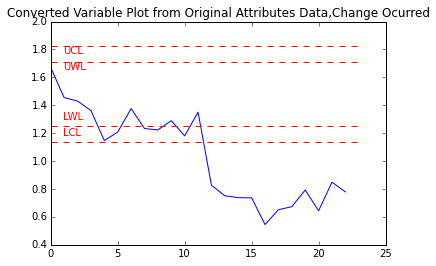

mean is in Shewart method:1.47933203687
UCL is in Shewart method: 1.82405215787
LCL is in Shewart method: 1.13461191586
UWL is in Shewart method: 1.70914545087
LWL is in Shewart method: 1.24951862286
range(5, 23)
[ 1.20795232]
Concept change occured at position 48of original attributes data
That corresponds to the 12th position on the converted data graph below
The change occur sample value is[ 0.82707956]


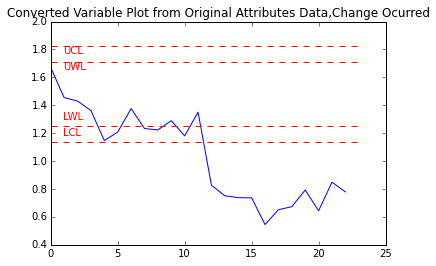

Reading posTriple_175.txt
Converted variable values are[array([ 1.13609049]), array([ 1.32167605]), array([ 1.43071131]), array([ 1.36218363]), array([ 1.21401295]), array([ 1.20795232]), array([ 1.37618581]), array([ 1.30023305]), array([ 1.49019293]), array([ 1.42323828]), array([ 1.44753786]), array([ 1.21766023]), array([ 0.96041289]), array([ 0.41785645]), array([ 0.73795716]), array([ 0.7366467]), array([ 0.74507273]), array([ 0.65145783]), array([ 0.6734874]), array([ 0.52637229]), array([ 0.84375064]), array([ 1.0486952]), array([ 0.91256944])]
mean is in Shewart method:1.3126653702
UCL is in Shewart method: 1.64008750699
LCL is in Shewart method: 0.985243233405
UWL is in Shewart method: 1.53094679473
LWL is in Shewart method: 1.09438394567
range(5, 23)
[ 1.20795232]
Concept change occured at position 48of original attributes data
That corresponds to the 12th position on the converted data graph below
The change occur sample value is[ 0.96041289]


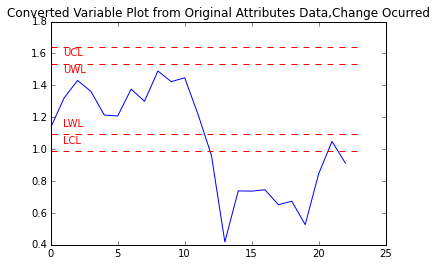

mean is in Shewart method:1.3126653702
UCL is in Shewart method: 1.64008750699
LCL is in Shewart method: 0.985243233405
UWL is in Shewart method: 1.53094679473
LWL is in Shewart method: 1.09438394567
range(5, 23)
[ 1.20795232]
Concept change occured at position 48of original attributes data
That corresponds to the 12th position on the converted data graph below
The change occur sample value is[ 0.96041289]


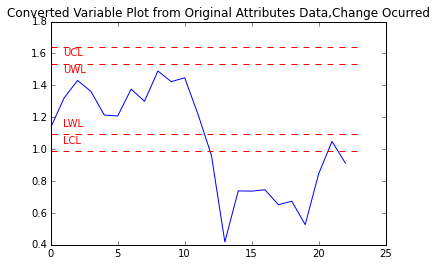

Converted variable values are[array([ 1.13609049]), array([ 1.32167605]), array([ 1.43071131]), array([ 1.36218363]), array([ 1.21401295]), array([ 1.20795232]), array([ 1.37618581]), array([ 1.30023305]), array([ 1.49019293]), array([ 1.42323828]), array([ 1.44753786]), array([ 1.21766023]), array([ 0.96041289]), array([ 0.41785645]), array([ 0.73795716]), array([ 0.7366467]), array([ 0.74507273]), array([ 0.65145783]), array([ 0.6734874]), array([ 0.52637229]), array([ 0.84375064]), array([ 1.0486952]), array([ 0.91256944])]
mean is in Shewart method:1.3126653702
UCL is in Shewart method: 1.64008750699
LCL is in Shewart method: 0.985243233405
UWL is in Shewart method: 1.53094679473
LWL is in Shewart method: 1.09438394567
range(5, 23)
[ 1.20795232]
Concept change occured at position 48of original attributes data
That corresponds to the 12th position on the converted data graph below
The change occur sample value is[ 0.96041289]


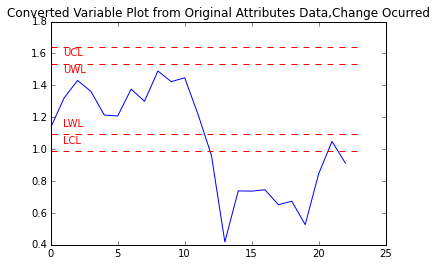

mean is in Shewart method:1.3126653702
UCL is in Shewart method: 1.64008750699
LCL is in Shewart method: 0.985243233405
UWL is in Shewart method: 1.53094679473
LWL is in Shewart method: 1.09438394567
range(5, 23)
[ 1.20795232]
Concept change occured at position 48of original attributes data
That corresponds to the 12th position on the converted data graph below
The change occur sample value is[ 0.96041289]


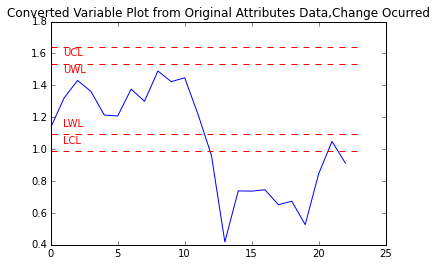

['negBinary.txt', -1, 'negFlata.txt', -1, 'negFlatb.txt', -1, 'negTriple.txt', -1, 'negWithRare.txt', -1, 'posBinary_150.txt', 17, 'posShiftDownMean_90.txt', 91, 'posShiftUpMean_70.txt', 71, 'posShiftUpVar_60.txt', 54, 'posShiftUpVar_70.txt', 69, 'posTriple2_160.txt', 14, 'posTripleDouble_175.txt', 12, 'posTriple_175.txt', 12]


In [28]:
import os
shiftDetect(os.getcwd())